# Formation Factor to permeability
Using Goudarzi again

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pystan
import arviz as az

sns.set(style='whitegrid')

In [2]:
df = (pd.read_excel('~/Dropbox/ROZ/data/Fontainebleau/Goudarzi et al. 2018.xlsx')
     .assign(Class=lambda x: x.Class.fillna(method='ffill'),
            porosity=lambda x: x.phi * 100)
     )
df.head()

,Class,Sample,L (mm),Dm (mm),phi,k (mD),tau_h,tau_e,F,tau_e/phi,phi_c,phi-phi_c,d_min,d_max,Dp,t=D/(3-D),m,t=2m,porosity
0,A1,1,2.6571,0.176,0.1410,706.0,1.4747,1.2897,21.3457,9.146809,0.01410,0.12690,12.252799,2527.638328,2.971481,104.192724,1.562459,3.124918,14.10
1,A1,2,2.6571,0.181,0.1546,933.0,1.4716,1.2766,18.4589,8.257439,0.01546,0.13914,12.252799,2527.638328,2.968486,94.196771,1.561693,3.123386,15.46
2,A1,3,2.6571,0.180,0.1642,1126.3,1.4695,1.2681,16.7000,7.722899,0.01642,0.14778,12.252799,2527.638328,2.966343,88.135429,1.558341,3.116683,16.42
3,A1,4,2.6571,0.182,0.1795,1504.1,1.4593,1.2529,14.3050,6.979944,0.01795,0.16155,12.252799,2527.638328,2.962877,79.811506,1.549045,3.098090,17.95
4,A1,5,2.6571,0.187,0.2037,2356.0,1.4291,1.2270,11.2323,6.023564,0.02037,0.18333,12.252799,2527.638328,2.957259,69.190137,1.520195,3.040391,20.37


[None, None]

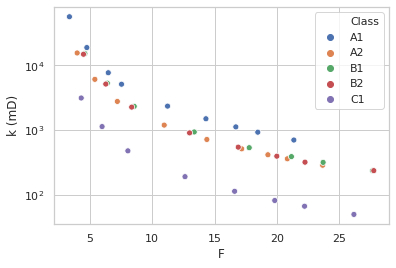

In [3]:
sns.scatterplot('F', 'k (mD)', hue='Class', data=df)
plt.gca().set(xscale='linear', yscale='log')

[Text(0, 0.5, 'Samples'), None, Text(0.5, 0, 'Prior distribution of $C_F$')]

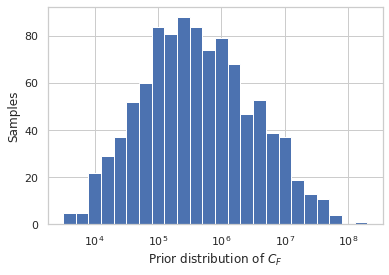

In [4]:
x = np.random.lognormal(13, 2, 1000)
bins = np.power(10, np.arange(3.5,8.5,.2))
bins
plt.hist(x, bins=bins);
plt.gca().set(xlabel='Prior distribution of $C_F$', xscale='log', ylabel='Samples')


In [5]:
model_code = """
data {
    int<lower=1> N;
    int<lower=1,upper=5> rock_class[N];
    vector[N] F;
    vector[N] perm;
}
transformed data {
    vector [N] logperm = log(perm);
}
parameters {
    real <lower=3e3, upper=1e8> C_F[5];
    real <lower=1, upper=6> beta_exp[5];
    real <lower=0> sigma_e[5];
}
model {
    beta_exp ~ normal(3, 1);
    C_F ~ lognormal(13, 2);
    for (i in 1:N){
        logperm[i] ~ normal(log(C_F[rock_class[i]]) 
                - beta_exp[rock_class[i]] * log(F[i]), 
            sigma_e[rock_class[i]]);
    }
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6868c8a925b444ee2af6fee7b0f74f6d NOW.


In [6]:
data = {
    'N': len(df.F), 
    'F':df.F, 
    'perm': df['k (mD)'],
    'rock_class':df.Class.astype('category').cat.codes + 1
}
fit = model.sampling(
    data=data, iter=8000, chains=4, warmup=2000, thin=1, seed=42, #adapt_delta = 1.0,
)
fit

Inference for Stan model: anon_model_6868c8a925b444ee2af6fee7b0f74f6d.
4 chains, each with iter=8000; warmup=2000; thin=1; 
post-warmup draws per chain=6000, total post-warmup draws=24000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C_F[1]       7.4e5  2944.8  2.7e5  3.8e5  5.8e5  6.9e5  8.4e5  1.3e6   8618    1.0
C_F[2]       2.6e5  741.98  7.5e4  1.5e5  2.2e5  2.5e5  3.0e5  4.3e5  10343    1.0
C_F[3]       4.1e5  1902.0  1.7e5  2.0e5  3.1e5  3.8e5  4.6e5  7.9e5   8211    1.0
C_F[4]       3.8e5  1921.5  1.8e5  1.7e5  2.8e5  3.5e5  4.3e5  7.7e5   8362    1.0
C_F[5]       7.2e4   443.9  3.7e4  3.4e4  5.5e4  6.7e4  8.1e4  1.4e5   6811    1.0
beta_exp[1]    2.3  1.2e-3   0.13   2.05   2.22    2.3   2.38   2.58  11313    1.0
beta_exp[2]   2.18  9.7e-4    0.1   1.98   2.12   2.18   2.24   2.39  11439    1.0
beta_exp[3]   2.27  1.4e-3   0.13   2.01   2.19   2.26   2.34   2.54   9220    1.0
beta_exp[4]   2.26  1.4e-3   0.15   1.98   2.18   2.26   2.34  

In [11]:
az_fit = az.from_pystan(
    fit,
    observed_data=["perm"], 
    coords={"Class": df.Class.unique()}, 
    dims = {"C_F": ["Class"], "beta_exp":["Class"], "sigma_e":["Class"]}
)

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backend

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4e69dc6d0>,
      dtype=object)

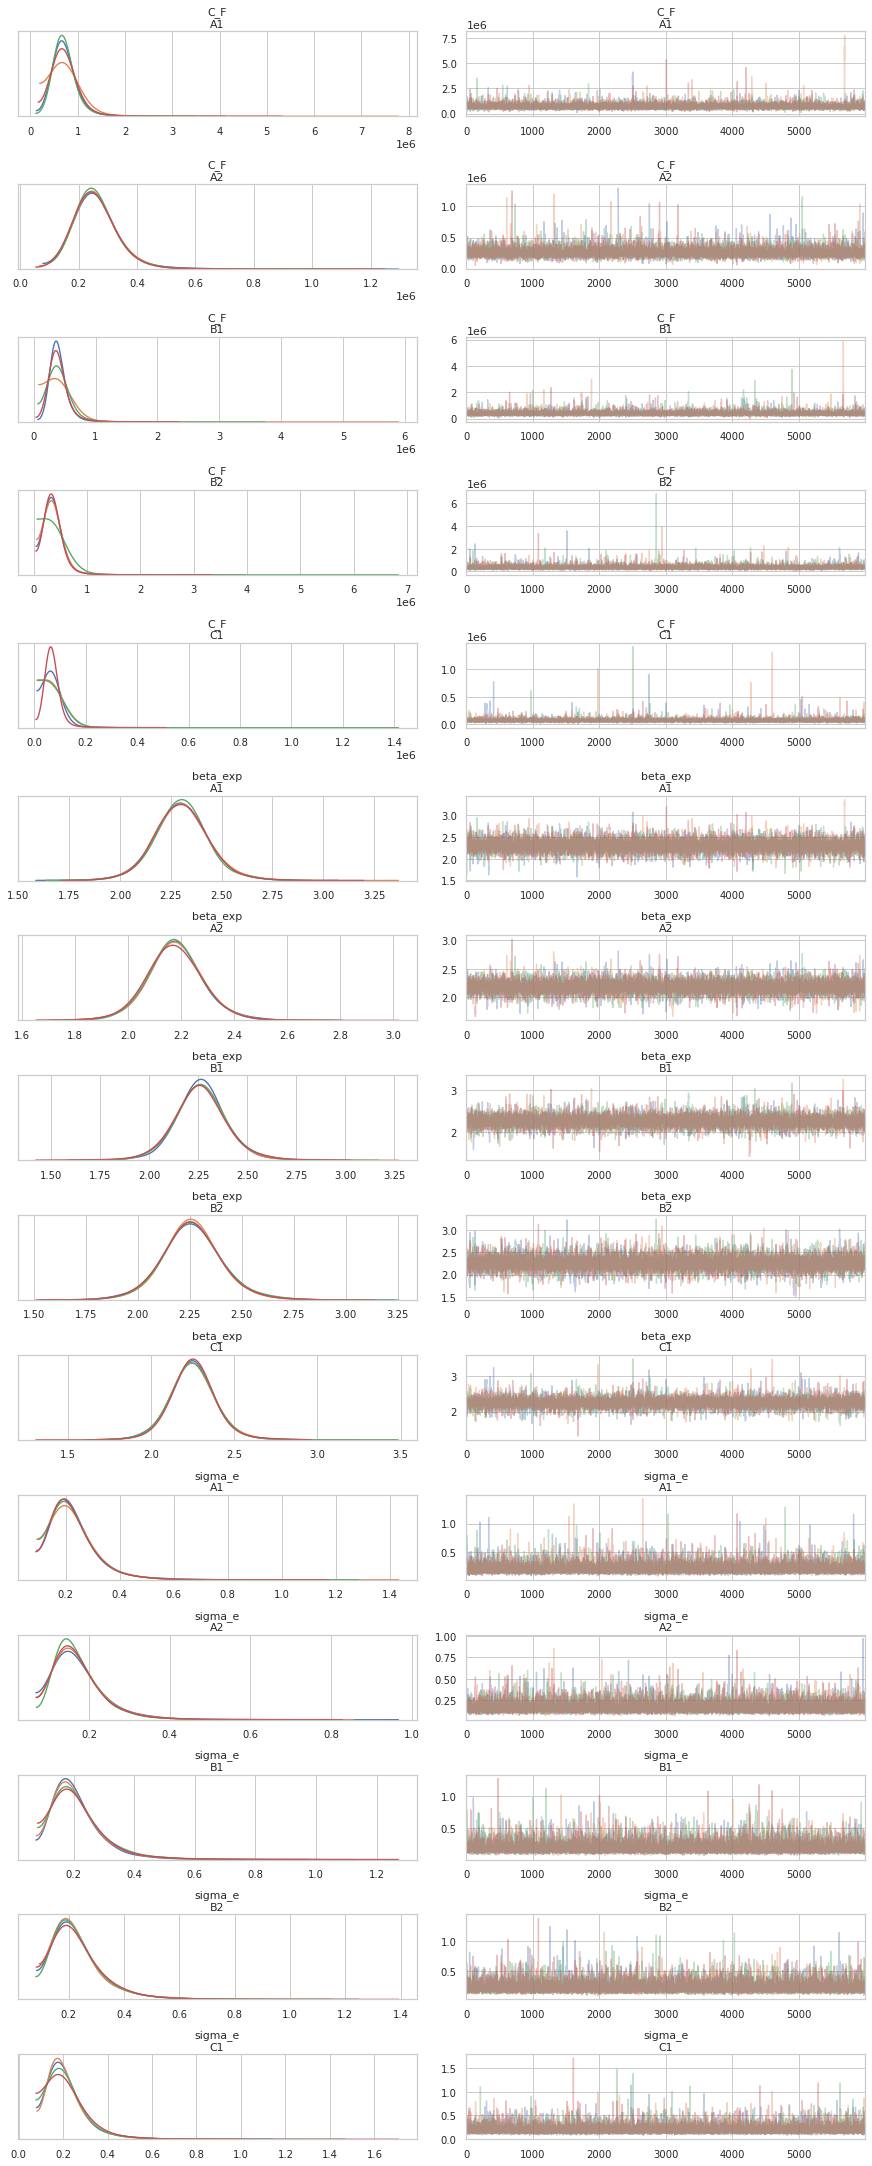

In [12]:
az.plot_trace(az_fit)

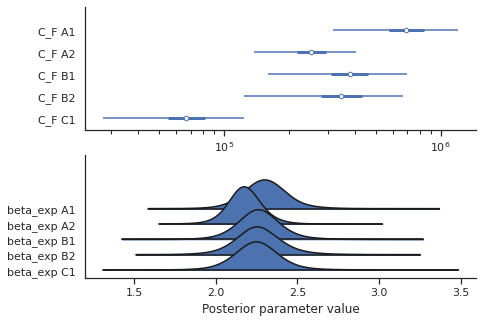

In [39]:
with sns.axes_style('ticks'):
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(7,5))
    az.plot_forest(
        az_fit, var_names=['C_F'], ax=ax1, kind='forestplot', combined=True, credible_interval=0.95
    )
    az.plot_forest(az_fit, var_names=['beta_exp'], ax=ax2, kind='ridgeplot', combined=True)
    ax1.set(xscale='log', title='')
    ax2.set(xlabel='Posterior parameter value')
    sns.despine()
    fig.savefig('bayes_figures/FormationFactor-perm-posterior.png', dpi=300, bbox_inches='tight')

In [69]:
CF = pd.DataFrame(fit['C_F'], columns=['A1', 'A2', 'B1', 'B2', 'C1'])

In [70]:
def difference_classes(posteriors, class_to_diff):
    out = ((posteriors - posteriors[class_to_diff])
          .drop(columns=[class_to_diff])
           .stack()
           .reset_index(level=1)
           .rename(columns={'level_1':'Class', 0:'Difference of C_F'})
          )
    return out

[(-300000.0, 1500000.0), Text(0.5, 0, 'Difference in C_F to Class A1')]

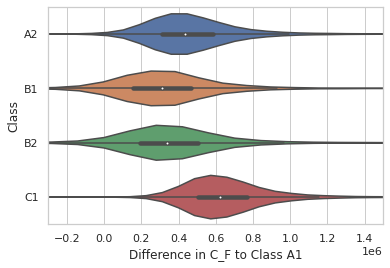

In [68]:
for col in posteriors.columns:
    difference = difference_classes()
    
diff_CF_C1 = fit['C_F'][:,[-1]] - fit['C_F'][:,:-1]
#plt.hist(, bins=np.linspace(-1e6,3e6,50));
g = sns.violinplot('Difference of C_F','Class', data=diff_CF_A1)
g.set(xlim=(-0.3e6, 1.5e6), xlabel='Difference in C_F to Class A1')

[None]

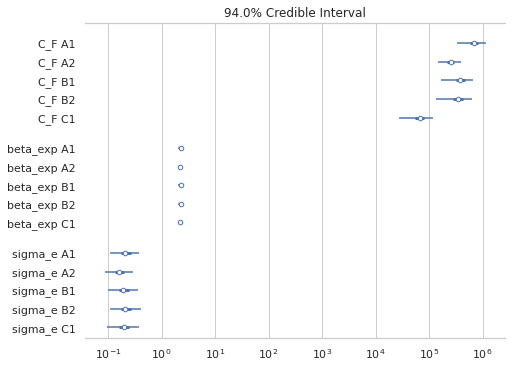

In [34]:
az.plot_forest(az_fit, figsize=(7,5), combined=True)
ax = plt.gca()
ax.set(xscale='log')

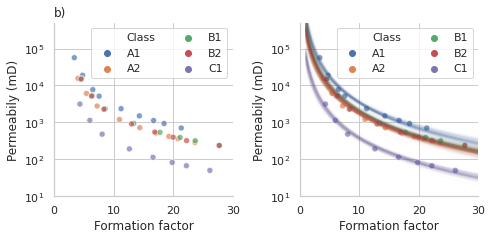

In [21]:
def log_posterior_examples(F_predict, fit, class_number=1, num_examples=100):
    beta = fit['beta_exp']
    F0 = fit['C_F']
    samples = np.random.choice(len(F0), num_examples)
    for e in samples:
        yield F0[e, class_number] * F_predict ** -beta[e, class_number]

F_fit = np.linspace(1, 30, 60)
pal = sns.color_palette()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
for class_number in range(5):
    for y in log_posterior_examples(F_fit, fit, class_number, 100):
        ax2.plot(F_fit, y, color=pal[class_number], alpha=.02)

sns.scatterplot('F', 'k (mD)', hue='Class', data=df, ax=ax1, alpha=0.7)
sns.scatterplot('F', 'k (mD)', hue='Class', data=df, ax=ax2, alpha=0.7)

axes_settings = dict(
    xlabel='Formation factor',
    xscale='linear',
    xlim=(0, 30),
    ylabel='Permeabily (mD)',
    yscale='log', 
    ylim=(10, 5e5)
)
ax1.set_title('a)', loc='left')
ax1.set(**axes_settings)
ax1.legend(ncol=2)

ax1.set_title('b)', loc='left')
ax2.set(**axes_settings)
ax2.legend(ncol=2)
sns.despine()
fig.tight_layout()
fig.savefig('bayes_figures/Goudarzi_F-k_fit.png', dpi=300, bbox_inches='tight')